# 2018-05-29 - Nouveau label
Pour génerer les clouds d'entrainement, utiliser le script "Generate_Motion_Clouds" - easy clouds.

# MotionCouds generation
On va génerer en chunks et en 8 orientations avec 6 MC/par orientation. On défini les paramètres :

In [ ]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21
print('Btheta list : \n'+str( bw_values*180/np.pi))

theta_list = np.linspace(0,np.pi,16)

Et on génère :

In [ ]:
for chunk_index, chunk in enumerate(bw_subsets) : #split into ranges
    for t in theta_list :
        if not os.path.exists('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t)): #si le folder n'existe pas on le crée
            os.makedirs('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t))

        for i_ax, B_theta in enumerate(chunk):
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
            im = mc.random_cloud(mc_i)

            imageio.imwrite('./clouds_boundary_BCE/chunk%s/%s/B0 %s.png' % (chunk_index , t, (B_theta*180/np.pi) ) , im[:, :, 0])

            #plt.imshow(im[:, :, 0], cmap=plt.gray())
            #plt.text(5, 29, r'$B_\theta=%.1f$°' % (B_theta*180/np.pi), color='yellow', fontsize=32)
            #plt.show()  

# Useful functions  
Le one-hot encoder et la génération du nouveau label :

In [ ]:
#One hot encoding, just in case BCE decides to work
def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

#generates a distribution of 
def generate_new_label(chunk, target):
    B_theta = np.mean(chunk)*180/np.pi

    Theta_zero = np.mean(np.linspace(0,np.pi,16))

    target_list =[]
    for i,t in enumerate(target):
        Theta = data_set.classes[target[i]]
        target_list.append(float(Theta))

    new_label = []
    for lab in range(len(target_list)):
        new_lab = math.cos(target_list[lab]-Theta_zero)
        new_lab = new_lab/4 * (B_theta) **2
        #print(new_lab)
        new_label.append(int(new_lab))

# Convolutional neural network

On défini le réseau, qui est celui de classification utilisé la première semaine :

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch 
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(1690, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

model = Net()
print(model)

On l'entraine sur des MC easy :

In [ ]:
import torch.optim as optim

#Criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=False,
                                             num_workers=1)
#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

#Plotting lists
total_step = len(train_loader)
loss_list = []
time_list = []
t=0

#Hyperparameters
epochs = 10

import time
start_time = time.time()
print("Started training")

for epoch in range(epochs) :
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Et maintenant on utilise le réseau sur des chunks de B_theta croissant avec le nouveau label :

In [ ]:
import math
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21

theta_list = np.linspace(0,np.pi,16)

ez_range_list = []
ez_acc_list = []

for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary_BCE/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)
    
    for data, target in data_loader:
        data = Variable(data, volatile=True)
        
        new_label = generate_new_label(chunk = chunk, target = target)
            
        new_label = torch.LongTensor(new_label)
        new_label = Variable(new_label)
        
        net_out = model(data)

        test_loss += criterion(net_out, new_label).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(new_label.data).sum() #sum up pred equals target in the batch
    
    test_loss /= len(data_loader.dataset) #loss = loss/length set
    #print("Chunk b_theta range : %s : %s" % (chunk[1]*180/np.pi, chunk[-1]*180/np.pi))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    ez_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    ez_acc_list.append(100 * correct /len(data_loader.dataset))

NameError: name 'ez_range_list' is not defined

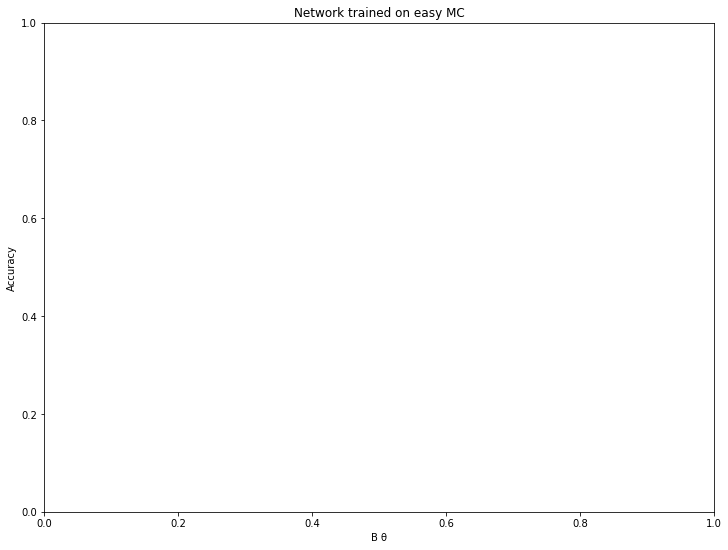

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on easy MC")

plt.plot(ez_range_list, ez_acc_list)
plt.plot([1,175],[6,6],'--', label = 'Randomness threshold')
plt.legend()
plt.show()

# TEST 

In [ ]:
import numpy as np
import math

B_theta = 3.14

theta = np.linspace(0, np.pi, 16)
theta_zero = np.mean(theta)

p = np.cos(theta-theta_zero)
p = p/(4*B_theta**2)

m = p*theta
m = m.sum()
v = p*((theta-m)**2)
v = v.sum()


print("Theta %s" %theta)
print("Theta_zero %s\n" %theta_zero)

print('p %s' %p)
print('Non-unique p values %s' % len(p))
print('Unique p values %s\n' % len(set(p)))

print('m %s' %m)
print('v %s' %v)

In [ ]:
import numpy as np
import math

def new_label(B_theta, verbose = False):
    theta = np.linspace(0, np.pi, 16)
    theta_zero = np.mean(theta)

    p = np.cos(theta-theta_zero)
    p = p/(4*B_theta**2)

    m = p*theta
    m = m.sum()
    v = p*((theta-m)**2)
    v = v.sum()

    if verbose :
        print("Theta %s" %theta)
        print("Theta_zero %s\n" %theta_zero)

        print('p %s' %p)
        print('Non-unique p values %s' % len(p))
        print('Unique p values %s\n' % len(set(p)))

        print('m %s' %m)
        print('v %s' %v)
    return p,v

new_label(30)

In [ ]:
N_b_theta = 300
nbr_chunks = 50 

b_theta_values = np.pi*np.logspace(-7,0, N_b_theta, base=2)
bw_subsets = np.array_split(b_theta_values, nbr_chunks)

vp_list = []
for b_theta in b_theta_values:
    vp_list.append(new_label(b_theta*180/np.pi)[1])
    
print(vp_list)

import matplotlib.pyplot as plt

plt.plot(b_theta_values, vp_list)
plt.xlabel('B_theta')
plt.ylabel('V')
plt.show()